In [ ]:
!pip install seaborn

In [ ]:
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt #for drawing statistical graphics - matplotlib
import seaborn as sns
import plotly.io as pio #interactive plots in colab

# visualization settings
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.facecolor'] = 'white'  #background is white
pio.renderers.default = 'colab'

# prophet
#it is a forecasting tool developed by FaceBook specifically for timeseries data
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet import Prophet #holidays and special events
# from prophet import hdays

# evaluation metric
from sklearn.metrics import mean_squared_log_error  #to calculate accuracy

# others
import itertools #for looping, PnC
from tqdm import tqdm #shows progress bar while running the loop

In [ ]:
## Mount Google drive folder
import sys

if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/OddSemester2024/ALA'
    DATA_DIR = DIR+'/Data/'
else:
    DATA_DIR = 'Data/'

Mounted at /content/drive


In [ ]:
#load sales data file
FILE = DATA_DIR + 'Sales_.csv'
sales = pd.read_csv(FILE)
sales.head(5)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112 entries, 0 to 3111
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sale_date              3112 non-null   object 
 1   product_unit_sales     3112 non-null   int64  
 2   discount_amount (Rs.)  3112 non-null   float64
 3   mrp_amount (Rs.)       3112 non-null   float64
 4   product                3112 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 121.7+ KB


In [ ]:
#changing object datatype of sale_date to datetime datatype
sales['sale_date'] = pd.to_datetime(sales['sale_date'], dayfirst=True)
sales.sort_values('sale_date', inplace=True)
sales['total_revenue'] = (sales['mrp_amount (Rs.)'] - sales['discount_amount (Rs.)'])
sales.dtypes
sales.head()

,sale_date,product_unit_sales,discount_amount (Rs.),mrp_amount (Rs.),product,total_revenue
225,2016-01-01,831,209547.22,1476259.0,shirt,1266711.78
164,2016-01-02,1209,398611.22,2140831.0,shirt,1742219.78
209,2016-01-03,1637,556444.28,2943443.0,shirt,2386998.72
160,2016-01-04,665,208259.20,1185095.0,shirt,976835.80
215,2016-01-05,704,240245.33,1259026.0,shirt,1018780.67


In [ ]:
#range of real time data (from when to when)
min_date, max_date = (sales['sale_date'].apply(['min', 'max']))
print(min_date)
print(max_date)

2016-01-01 00:00:00
2024-08-19 00:00:00


In [ ]:
#total no of rows
total_shirt = sales['product'].value_counts().head(1)
total_shirt

,count
product,
shirt,3112


In [ ]:
#no of products (shirts) sold every year from 2016 to 2024
yearly_sales = sales.groupby(sales['sale_date'].dt.year)['product_unit_sales'].sum()
yearly_sales

,product_unit_sales
sale_date,
2016,336955
2017,310557
2018,319559
2019,277193
2020,147819
2021,188996
2022,250505
2023,230842
2024,125472


In [ ]:
#first 3 year sales
top_3_years = sales['sale_date'].dt.year.value_counts().head(3)
top_3_years
sales_top_years_data = sales[ sales['sale_date'].dt.year.isin(top_3_years.index)]
sales_top_years_data.head()

,sale_date,product_unit_sales,discount_amount (Rs.),mrp_amount (Rs.),product,total_revenue
225,2016-01-01,831,209547.22,1476259.0,shirt,1266711.78
164,2016-01-02,1209,398611.22,2140831.0,shirt,1742219.78
209,2016-01-03,1637,556444.28,2943443.0,shirt,2386998.72
160,2016-01-04,665,208259.20,1185095.0,shirt,976835.80
215,2016-01-05,704,240245.33,1259026.0,shirt,1018780.67


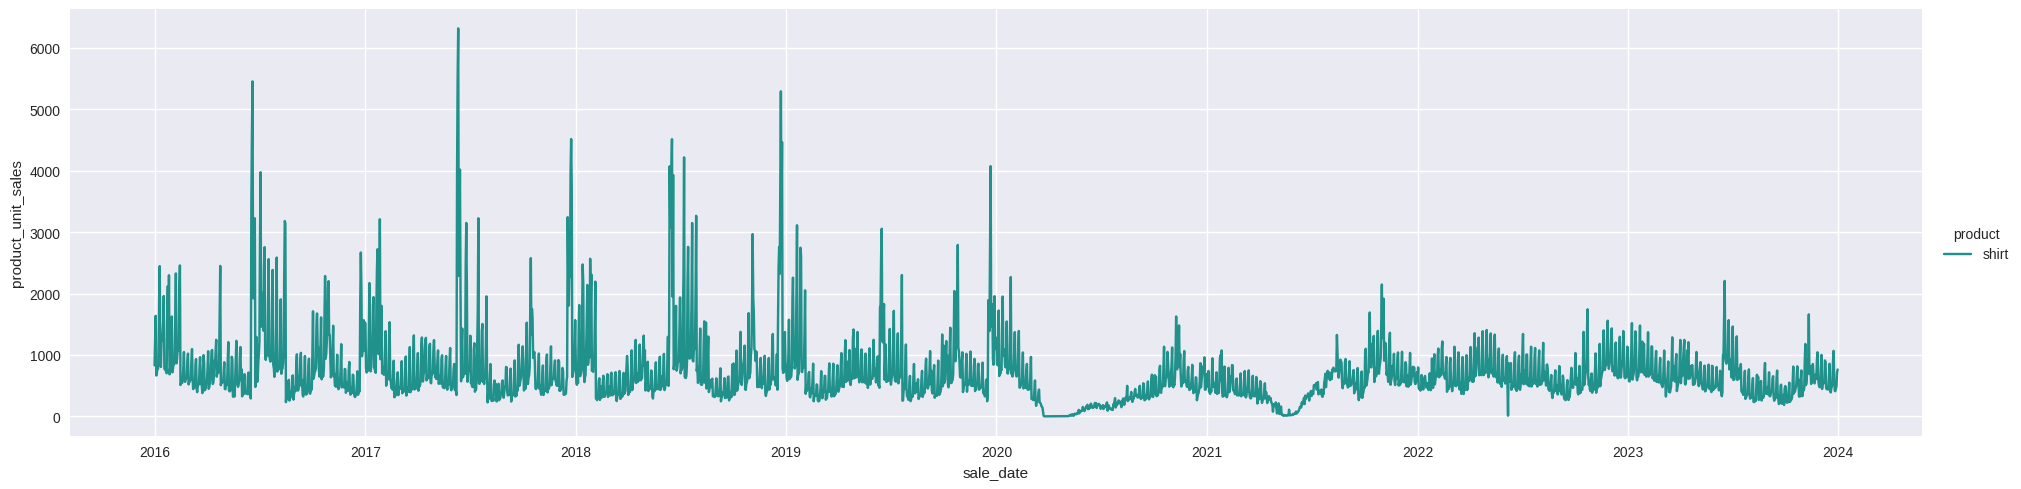

In [ ]:
#plotting all 8 years sales
import matplotlib.pyplot as plt
all_years = sales['sale_date'].dt.year.value_counts().head(8)
sales_years_data = sales[sales['sale_date'].dt.year.isin(all_years.index)]
sns.relplot(data=sales_years_data,
            kind='line',
            x='sale_date',
            y='product_unit_sales',
            hue = 'product',
            palette='viridis',
            height=5,
            aspect=19.5/5)
plt.show()

In [ ]:
#forecasting
#renaming columns in sales to ds and y for Prophet()
sales['sale_date'] = pd.to_datetime(sales['sale_date'], dayfirst=True)
sales = sales.rename(columns={'sale_date': 'ds', 'product_unit_sales': 'y'})
model = Prophet()
model.fit(sales)

#6 refers to no of months which is indicated by M in freq
future = model.make_future_dataframe(periods=6, freq='M')
#future = future[future['ds'] > max_date]

forecast = model.predict(future)

#predicting future 6 months
forecast_next_6_months = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)
print(forecast_next_6_months)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2dwp7r0/k4cab7ax.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp2dwp7r0/t2gogubc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78764', 'data', 'file=/tmp/tmpp2dwp7r0/k4cab7ax.json', 'init=/tmp/tmpp2dwp7r0/t2gogubc.json', 'output', 'file=/tmp/tmpp2dwp7r0/prophet_model4uzgxmtk/prophet_model-20241225062755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:27:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:27:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'M' is deprecated and will be removed in a future version,

             ds        yhat  yhat_lower   yhat_upper
3112 2024-08-31  557.191889   15.824472  1069.074539
3113 2024-09-30  215.185219 -320.793510   787.187700
3114 2024-10-31  507.808288  -57.220538  1068.356012
3115 2024-11-30  557.092699   25.123641  1093.173170
3116 2024-12-31  593.616731   23.123999  1187.630496
3117 2025-01-31  591.615731   63.694244  1124.410916


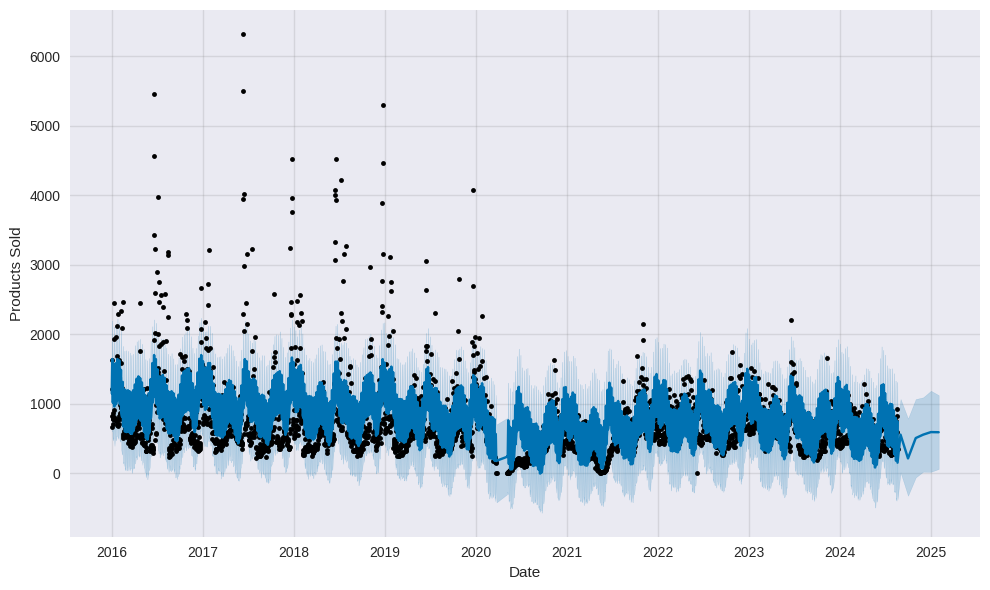

In [ ]:
forecast_result =forecast['yhat'] # Extract the forecasted values from the 'yhat' column
forecast_add_components =forecast['trend'] + forecast['weekly'] + forecast['yearly'] # Calculate the sum of the trend, weekly, and yearly components

# Check if the forecasted values are equal to the sum of the components
# Round to 10 decimal places to handle floating-point precision issues
(forecast_result.round(10) == forecast_add_components.round(10)).all()
fig = model.plot(forecast, xlabel='Date', ylabel='Products Sold')
#The black points in the plot shows the actual time series, and the blue line shows the fitted time series along with its forecasted values 6 months into the future.

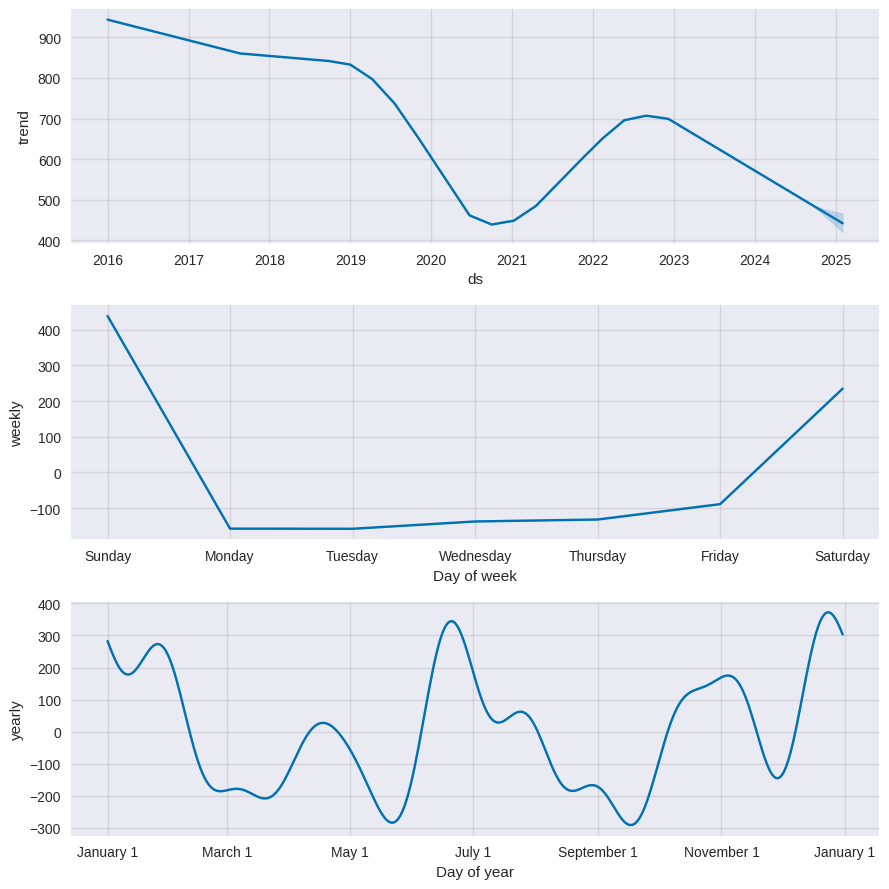

In [ ]:
# This includes the trend, weekly, and yearly components of the forecast
fig = model.plot_components(forecast)

In [ ]:
# Generate an interactive plot using Plotly for the forecast
plot_plotly(model, forecast)

In [ ]:
# Generate an interactive plot of the forecast components
plot_components_plotly(model, forecast)

/usr/local/lib/python3.10/dist-packages/plotly/io/_json.py:560: UserWarning:

Discarding nonzero nanoseconds in conversion.



In [ ]:
x = 1
x = x > -5
x

True